In [1]:
# Database used: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data
# TODO Maybe we should not be using pictures of glaciers, mountains, etc., just one single type of image
#  (for now)

import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np

2024-01-06 13:06:15.786425: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-06 13:06:15.821527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 13:06:15.821600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 13:06:15.822801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 13:06:15.828645: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-06 13:06:15.829066: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
train_image_paths = {'buildings': [],
           'forest': [],
           'glacier': [],
           'mountain': [],
           'sea': [],
           'street': []
          }
test_image_paths = {'buildings': [],
           'forest': [],
           'glacier': [],
           'mountain': [],
           'sea': [],
           'street': []
          }
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [3]:
DATASET_PATH = "../dataset"

In [4]:
def go_though_database(database_path):
    for path, subdirs, files in os.walk(database_path):
        for file in files:
            #print(path)
            current_path = path
            if 'seg_train/seg_train' in path:
                file_path = os.path.join(path, file)
                for category in categories:
                    if category in file_path:
                        train_image_paths[category].append(file_path)
            if 'seg_test/seg_test' in path:
                file_path = os.path.join(path, file)
                for category in categories:
                    if category in file_path:
                        test_image_paths[category].append(file_path)

In [5]:
go_though_database(DATASET_PATH)

In [6]:
def create_mask(image):
    img_height, img_width = image.shape[:2] #(150, 150, 3)
    mask = 255 * np.ones_like(image) # matrix of ones -> white image
    blackout_start_index = img_width // 3
    
    for i in range(img_height):
        for j in range(img_width):
            if j >= blackout_start_index and j < 2*blackout_start_index:
                mask[i, j] = 0

    return mask

In [7]:
# applys mask to the image 
def edit_image(image_path):
    image = cv2.imread(image_path)
    mask = create_mask(image)
    edited_image = cv2.bitwise_and(image, mask)
    return edited_image


In [8]:
def save_edited_images(image_paths, category, set_type):
    directory = f"../dataset/edited/{set_type}/{category}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    for index, image_path in enumerate(image_paths):
        image = edit_image(image_path)
        edited_image_name = image_path.split('/')[-1].split('.')[0] + '_edited.jpg'
        edited_image_path = os.path.join(directory, edited_image_name)
        # (input_image_path, output_image_path)
        image_paths[index] = (edited_image_path, image_path)
        cv2.imwrite(edited_image_path, image)
        

In [9]:
for category in categories:
    save_edited_images(train_image_paths[category], category, "train")
    save_edited_images(test_image_paths[category], category, "test")

In [10]:
MAX_PIXEL_COLOR_VALUE = 255.0

In [11]:
def load(input_image_path, output_image_path):
    input_image = tf.io.read_file(input_image_path)
    input_image = tf.io.decode_jpeg(input_image)
    input_image = tf.cast(input_image, tf.float32)
    output_image = tf.io.read_file(output_image_path)
    output_image = tf.io.decode_jpeg(output_image)
    # TODO [vukan] : Why is this needed? (Check with Kaca)
    output_image = tf.cast(output_image, tf.float32)
    return input_image, output_image

In [12]:
train_image_paths['buildings'][-1]

('../dataset/edited/train/buildings/463_edited.jpg',
 '../dataset/seg_train/seg_train/buildings/463.jpg')

2024-01-06 13:09:54.422770: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


(150, 150, 3)
(150, 150, 3)


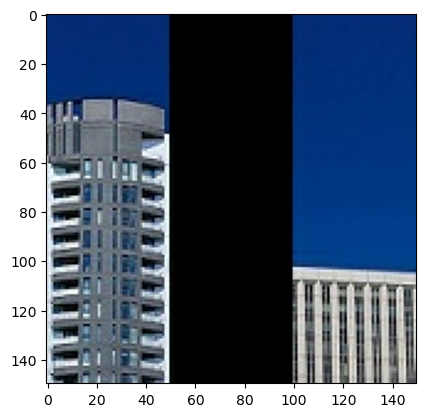

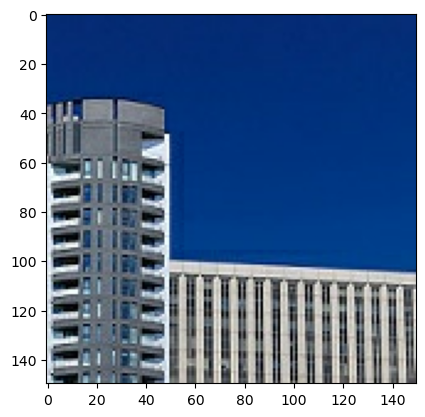

In [13]:
input_image_path, output_image_path = train_image_paths['buildings'][-1]
input_image, output_image = load(input_image_path, output_image_path)
print(input_image.shape)
print(output_image.shape)
plt.figure()
plt.imshow(input_image / MAX_PIXEL_COLOR_VALUE)
plt.figure()
plt.imshow(output_image / MAX_PIXEL_COLOR_VALUE)

In [14]:
def normalize_images(input_image, output_image) :
    input_image = (input_image / (MAX_PIXEL_COLOR_VALUE / 2)) - 1 
    output_image = (output_image / (MAX_PIXEL_COLOR_VALUE / 2)) - 1  
    return input_image, output_image

In [15]:
def resize_images(input_image, output_image, height, width): 
    input_image = tf.image.resize(input_image, [height, width])
    # ], method=tf.image.ResizeMethod.
    output_image = tf.image.resize(input_image, [height, width])
    return input_image, output_image

In [16]:
# TODO [vukan] : Check with Kaca, are we adding the resizing and jittering?
# Resizing is a must, because our Generator takes in images with the shape of (256, 256, 3)

In [17]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

In [18]:
def make_image_set(image_paths) :
    # lets firstly try out with only one category, and later try with all of them
    category = "street"
    images = []
    # for category in categories:
    for image_path_pair in image_paths[category]:
        input_image_path, output_image_path = image_path_pair
        input_image, output_image = load(input_image_path, output_image_path)
        input_image, output_image = resize_images(input_image, output_image, IMAGE_HEIGHT, IMAGE_WIDTH)
        images.append(normalize_images(input_image, output_image))
    return images

In [19]:
train_images = make_image_set(train_image_paths)
#test_images = make_image_set(test_image_paths)

(256, 256, 3)
(256, 256, 3)


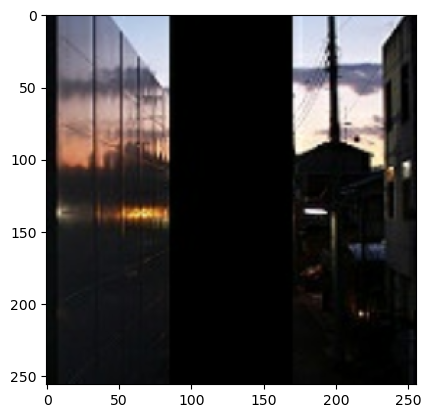

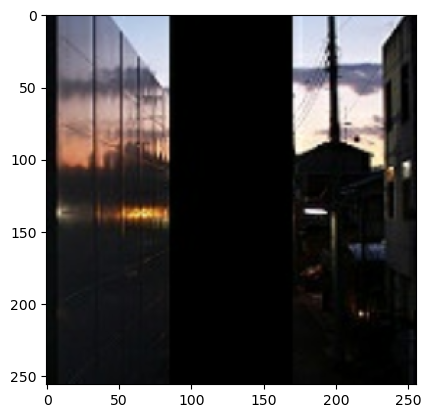

In [20]:
input_image, output_image = train_images[25]

print(input_image.shape)
plt.figure()
plt.imshow(input_image * 0.5 + 0.5)
print(output_image.shape)
plt.figure()
plt.imshow(output_image* 0.5 + 0.5)

In [21]:
%run Generator.ipynb

Model: "Generator(U-Net)"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3392      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131712    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          525568    ['sequential_1[0][0]']        
                                                                                   

In [22]:
generator = Generator(input_image.shape)

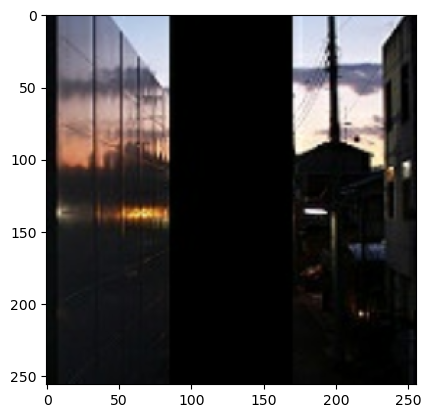

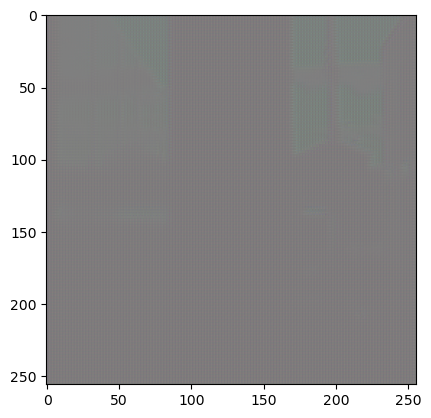

In [23]:
generator_model = generator.model
generator_result = generator_model(input_image[tf.newaxis, ...], training=False)

plt.figure()
plt.imshow(input_image *  0.5 + 0.5)
plt.figure()
plt.imshow(generator_result[0, ...] *  0.5 + 0.5)
 

In [24]:
%run Discriminator.ipynb

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_14 (Concatenat  (None, 256, 256, 6)          0         ['input_image[0][0]',         
 e)                                                                  'target_image[0][0]']        
                                                                                                  
 sequential_30 (Sequential)  (None, 128, 128, 64)         6464      ['concatenate_14[0][0]']  

In [26]:
discriminator = Discriminator(input_image.shape)